<h1>Celebrity Recognition</h1>
<h4>di Giuseppe Cosimo Alfio Bellamacina - 1000030349</h4>
Il programma riconosce la celebrità presente in un'immagine e la mostra in un'interfaccia grafica.

Innanzitutto è necessario importare le **librerie** necessarie per il funzionamento del programma.

In [1]:
import os
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Subset
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit # StratifiedGroupKFold
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from random import randint
from collections import Counter
from shutil import copy, rmtree

Si possono definire delle **costanti** che verranno utilizzate nel programma.

In [2]:
# Percorsi dei dataset
ORIGINAL_SET_DIR = './celebrityData' # cartella contenente le immagini originali
RESIZED_SET_DIR = './celebrityDataResized' # cartella contenente le immagini che sono state solo ridimensionate
AUGMENTED_SET_DIR = './celebrityDataAugmented' # cartella contenente le immagini trasformate e ridimensionate

# Parametri di preprocessing
DIM = 64 # dimensione delle immagini
BATCH_SIZE = 64 # numero di immagini per batch
FOLDS = 5 # numero di fold per la cross validation
SPLIT_RATIO = 0.2 # percentuale di immagini da usare per il validation set

# Optimizer
LR = 0.001 # learning rate
DECAY = 0.0001 # weight decay

# Scheduler
STEP_SIZE = 12 # ogni quanti epoche viene applicato il fattore gamma
GAMMA = 0.1 # fattore di decay del learning rate

# Rete neurale
EXPANSION = 1 # fattore di espansione del numero di canali

# Addestramento
NUM_EPOCHS = 20 # numero di epoche
PATIENCE = 3 # numero di epoche senza miglioramenti prima di fermare l'addestramento
DELTA = 0.03 # intervallo di soglia per l'indice di miglioramento per l'early stopping

# Valutazione
CONFUSION_DATA_EPOCHS = 2 # numero delle ultime epoche da cui salvare i dati per la matrice di confusione



<h2>PreProcessing</h2>
Per prima cosa è necessario <strong>preparare</strong> le immagini per l'addestramento e il successivo riconoscimento, ma è anche importante disporre di molti dati di partenza su cui addestrare il modello, per cui si processa il <strong>Dataset Originale</strong> con un programma separato chiamato <code>imageAugmentation.py</code> che tramite l'applicazione di alcune trasformazioni alle immagini del dataset originale, genera un dataset più grande e vario.
Le trasformazioni eseguite sono le seguenti:
<ul>
    <li> Resizing a 474x474 (standardizzazione iniziale delle dimensioni) </li>
    <li> Flip orizzontale </li>
    <li> Flip verticale </li>
    <li> Rotazione random tra -30° e 30° </li>
    <li> Rotazione 90° in senso orario </li>
    <li> Rotazione 90° in senso antiorario </li>
    <li> Modifica della luminosità random tra -0.5 e 0.5 </li>
    <li> Modifica del contrasto random tra 0.5 e 1.5 </li>
    <li> Modifica della saturazione random tra 0.5 e 1.5 </li>
    <li> Modifica hue random tra 0.5 e 1.5 </li>
    <li> Filtro scala di grigi </li>
    <li> Prospettiva a sinistra </li>
    <li> Prospettiva a destra </li>
</ul>

Queste modifiche sono state eseguite singolarmente per ogni immagine del dataset originale e le immagini risultanti sono state aggiunte al dataset.

Si definisce la funzione <code>transform</code> che determina la trasformazione dell'immagine in modo da poterla utilizzare per il riconoscimento.

In [3]:
transform = transforms.Compose([
    transforms.Resize((DIM, DIM), interpolation=2),
    transforms.ToTensor()
])

Si utilizzerà un metodo di **cross-validation** per la valutazione del modello, dunqe si definisce prima la funzione <code>kFoldCross()</code>.

In [4]:
def kFoldCross(subsets, k, num_folds):
    train_sub_sets, val_sub_sets = subsets
    train_set = train_sub_sets[k % num_folds]
    val_set = val_sub_sets[k % num_folds]
    return train_set, val_set

A questo punto si suddivide il dataset in tanti **Subsets di training** e tanti **Subsets di validation** quanti sono i **Folds** definiti.
La suddivisione è effeuttuata in modo che ogni subset contenga un numero di immagini per ogni classe proporzionale al numero di immagini per quella classe nel dataset originale.

In [5]:
dataset = ImageFolder(AUGMENTED_SET_DIR, transform=transform) # viene usato il dataset aumentato

random_seed = randint(0, 1000)
torch.manual_seed(random_seed)

sss = StratifiedShuffleSplit(n_splits=FOLDS, test_size=SPLIT_RATIO, random_state=random_seed)

train_sets, val_sets = [], []
for train_index, val_index in sss.split(dataset, dataset.targets):
    train_sets.append(Subset(dataset, train_index))
    val_sets.append(Subset(dataset, val_index))

print('Dimensione di ciascun Train Set:\t', len(train_sets[0]))
print('Dimensione di ciascun Validation Set:\t', len(val_sets[0]))

Dimensione di ciascun Train Set:	 49594
Dimensione di ciascun Validation Set:	 12399


Ora che il dataset è pronto, si può visualizzare la sua dimensione e metterla a confronto con quella del dataset originale.

In [6]:
original_dataset = ImageFolder(ORIGINAL_SET_DIR, transform=None)

print('Dataset Originale:\t\t', len(original_dataset))
print('Dataset dopo DataAugmentation:\t', len(dataset))

Dataset Originale:		 4769
Dataset dopo DataAugmentation:	 61993


Ci sono tante classi differenti quante sono le persone inserite nel dataset, ovvero:

In [7]:
classes = dataset.classes

def printLabels(classes):
    n_classes = len(classes)
    print('\33[1;33mClassi:\33[0m')
    for i in range(n_classes//2):
        print(f'{i+1}. {classes[i]}', end='')
        print_len = len(str(i+1)) + len(classes[i]) + 2
        print(' ' * (30 - print_len), f'{i+1+n_classes//2}. {classes[i+n_classes//2]}')

printLabels(classes)

Classi:
1. Ana de Armas                17. Keanu Reeves
2. Angelina Jolie              18. Leonardo DiCaprio
3. Benedict Cumberbatch        19. Mark Ruffalo
4. Brad Pitt                   20. Megan Fox
5. Brie Larson                 21. Natalie Portman
6. Chris Evans                 22. Nicole Kidman
7. Chris Hemsworth             23. Paul Rudd
8. Denzel Washington           24. Robert Downey Jr
9. Elizabeth Olsen             25. Ryan Gosling
10. Giuseppe Bellamacina       26. Sandra Bullock
11. Hugh Jackman               27. Scarlett Johansson
12. Jenna Ortega               28. Tom Cruise
13. Jennifer Lawrence          29. Tom Hanks
14. Johnny Depp                30. Tom Holland
15. Josh Brolin                31. Vin Diesel
16. Kate Winslet               32. Will Smith


Le immagini non sono distribuite in modo uniforme tra le classi, infatti alcune classi hanno più immagini di altre.

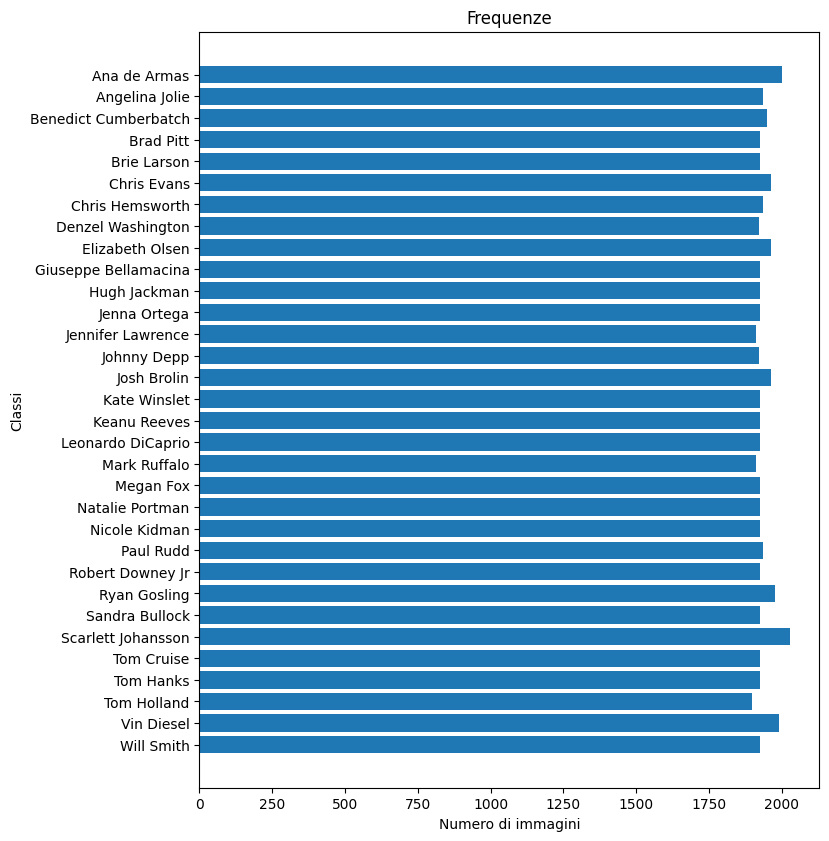

In [8]:
class_freq = Counter(dataset.targets)
class_freq = list(class_freq.values())

fig, ax = plt.subplots(figsize=(8,4))
ax.barh(classes, class_freq)
ax.invert_yaxis()
plt.subplots_adjust(top=2.0)
plt.title('Frequenze')
plt.xlabel('Numero di immagini')
plt.ylabel('Classi')

plt.show()

Si può visualizzare un **batch** di esempio. Ecco il primo:

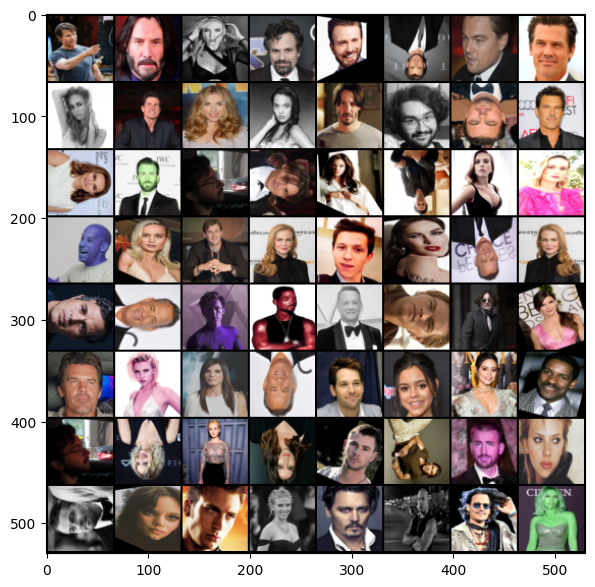

In [9]:
for images, labels in DataLoader(train_sets[0], batch_size=BATCH_SIZE, shuffle=True):
   fig, ax = plt.subplots(figsize=(14, 7))
   ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
   break

plt.show()

<h2>La Rete Neurale</h2>
La rete neurale implementata è una versione semplificata della <strong>ResNet-18</strong>, una delle architetture ResNet (Residual Networks) popolari. La ResNet è nota per l'uso di <strong>blocchi residuali</strong>, che aiutano a mitigare il problema della scomparsa del gradiente durante la retropropagazione in reti neurali molto profonde.


In [10]:
# Blocco ResNet base
class BasicBlock(nn.Module):
    expansion = EXPANSION
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()  
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True) # sovrascrive l'input risparmiando memoria
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential() # collegamento diretto
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x) # si somma il collegamento diretto dell'input
        out = self.relu(out)
        return out


# Architettura ResNet-18
class ResNet18(nn.Module):
    def __init__(self, num_classes, in_channels=DIM):
        super(ResNet18, self).__init__()
        self.in_channels = in_channels

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()

        self.layer1 = self.make_layer(BasicBlock, in_channels, 2, stride=1)
        self.layer2 = self.make_layer(BasicBlock, 2 * in_channels, 2, stride=2)
        self.layer3 = self.make_layer(BasicBlock, 4 * in_channels, 2, stride=2)
        self.layer4 = self.make_layer(BasicBlock, 8 * in_channels, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # il tensore viene ridotto ad una dimensione
        self.fc = nn.Linear(8 * in_channels * BasicBlock.expansion, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers) # restituisce il blocco di layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x
    
    def extract_last_layer_feature_maps(self, x):
        # Questa funzione estrae le feature maps dell'ultimo blocco convoluzionale
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        last_layer_feature_maps = self.layer4(x)

        return last_layer_feature_maps

<h2>Preparazione al training</h2>
Prima di poter avviare il training è necessario definire alcune funzioni che verranno utilizzate durante il training stesso e istanziare alcune strutture dati e oggetti che serviranno per il training e la valutazione del modello.

Si verifica la disponibilità di una **GPU** per il training.

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("\33[1;32mLa GPU e' disponibile\33[0m")
else:
    device = torch.device("cpu")
    print("\33[1;31mLa GPU non e' disponibile, si passa alla CPU\33[0m")

La GPU e' disponibile


Ora si istanziano:
- La rete neurale;
- La funzione di costo: **CrossEntropyLoss** con **pesi** per ogni classe calcolati in modo automatico in base alla **frequenza** delle immagini di quella classe nel dataset;
- L'ottimizzatore: Adam con **learning rate** iniziale pari a 0.001 e **weight decay** pari a 0.0001;
- Lo scheduler: ogni **step_size** epochs moltiplica il learning rate **lr** di un valore **gamma** così da ridurlo.

In [12]:
model = ResNet18(num_classes=len(classes), in_channels=DIM).to(device) # spostiamo il modello sulla GPU se disponibile

# assegno il peso ad ogni classe in base alla sua frequenza
class_weights = [class_freq[i] / len(dataset) for i in range(len(classes))]

loss_func = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights)).to(device)
optimizer = Adam(model.parameters(), lr=LR, weight_decay=DECAY) # weight_decay è la L2 regularization (penalizzazione dei pesi)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA) # diminuiamo il learning rate dopo step_size epoche

Si può stampare un **riassunto** della rete neurale.

In [13]:
summary(model, input_size=(3, DIM, DIM), batch_size=BATCH_SIZE, device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 64, 32, 32]           9,408
       BatchNorm2d-2           [64, 64, 32, 32]             128
              ReLU-3           [64, 64, 32, 32]               0
         MaxPool2d-4           [64, 64, 16, 16]               0
            Conv2d-5           [64, 64, 16, 16]          36,864
       BatchNorm2d-6           [64, 64, 16, 16]             128
              ReLU-7           [64, 64, 16, 16]               0
            Conv2d-8           [64, 64, 16, 16]          36,864
       BatchNorm2d-9           [64, 64, 16, 16]             128
             ReLU-10           [64, 64, 16, 16]               0
       BasicBlock-11           [64, 64, 16, 16]               0
           Conv2d-12           [64, 64, 16, 16]          36,864
      BatchNorm2d-13           [64, 64, 16, 16]             128
             ReLU-14           [64, 64,

Si definiscono le funzioni per il training e la validation. Le funzioni si chiamano <code>training</code> e <code>validation</code>.

In [14]:
def training(model, loss_func, optimizer, train_dl, curr_epoch):
    model.train()
    correct = total = 0
    running_loss = 0.0
    for images, labels in tqdm(train_dl, desc=f"Epoch {curr_epoch + 1}/{NUM_EPOCHS} Training MODE", unit="batch", leave=False):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        optimizer.step()
    average_loss = running_loss / len(train_dl)
    accuracy = 100 * correct / total
    print(f"\33[1;37mTraining {curr_epoch + 1}/{NUM_EPOCHS}\33[0m -> \33[31mLoss\33[0m: {average_loss:.4f}, \33[32mAccuracy\33[0m: {accuracy:.2f}%")
    return average_loss, accuracy

def validation(model, loss_func, val_dl, curr_epoch, y_true, y_pred):
    model.eval()
    correct = total = 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_dl, desc=f"Epoch {curr_epoch + 1}/{NUM_EPOCHS} Validation MODE", unit="batch", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_func(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true[curr_epoch].extend(labels.cpu().numpy()) # per il calcolo della matrice di confusione
            y_pred[curr_epoch].extend(predicted.cpu().numpy()) # per il calcolo della matrice di confusione
    average_loss = running_loss / len(val_dl)
    accuracy = 100 * correct / total
    print(f"\33[1;37mValidation {curr_epoch + 1}/{NUM_EPOCHS}\33[0m -> \33[31mLoss\33[0m: {average_loss:.4f}, \33[32mAccuracy\33[0m: {accuracy:.2f}%")
    print("____________________________________________________")
    return average_loss, accuracy

Se durante l'addestramento non si verifica alcun miglioramento significativo per un dato numero di epoche consecutive, l'addestramento viene interrotto. Si definisce la funzione <code>earlyStopping()</code> per questo scopo.

In [15]:
def earlyStopping(val_losses, patience, delta):
    count = patience
    if len(val_losses) < patience: # se non abbiamo ancora abbastanza epoche per fare confronti
        return False
    elif len(val_losses) == NUM_EPOCHS - 1: # se siamo all'ultima epoca
        return False
    else:
        last_losses_sum = sum(val_losses[-patience:])
        last_losses_avg = last_losses_sum / patience
        for i in range(1, patience+1):
            if val_losses[-i] < last_losses_avg + delta/2 and val_losses[-i] > last_losses_avg - delta/2:
                count -= 1
    return count == 0

Si deve anche definire una funzione <code>loadData()</code> per caricare i diversi subset ad ogni epoch.

In [16]:
def loadData(subsets, k,num_folds, batch_size):
    train_set, val_set = kFoldCross(subsets, k, num_folds)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
    return train_loader, val_loader

In più si creano 4 vettori che conterranno i dati per il grafico che mostrerà l'andamento dell'accuratezza e della funzione di costo durante l'addestramento e altri 2 vettori che conterranno le etichette reali e quelle predette per il calcolo della matrice di confusione.

In [17]:
# Dati per l'analisi e la valutazione
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Dati per la matrice di confusione
y_true = [] # si implementa come una lista di liste per poter salvare i valori di y_true e y_pred per ogni epoca
y_pred = []

<h2>Addestramento</h2>
Il training può essere avviato.

In [18]:
print("\33[1;33mTraining avviato\33[0m")
for epoch in range(NUM_EPOCHS):
    train_dl, val_dl = loadData((train_sets, val_sets), epoch, FOLDS, BATCH_SIZE)
    train_loss, train_acc = training(model, loss_func, optimizer, train_dl, epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    y_pred.append([])
    y_true.append([])
    val_loss, val_acc = validation(model, loss_func, val_dl, epoch, y_true, y_pred)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    if earlyStopping(val_losses, PATIENCE, DELTA):
        print("\33[1;35mEarly Stopping\33[0m")
        break
    scheduler.step()
print("\33[1;32mTraining terminato\33[0m")

Training avviato


Training 1/20 -> Loss: 2.3501, Accuracy: 32.87%


Validation 1/20 -> Loss: 1.7436, Accuracy: 49.39%
____________________________________________________


Training 2/20 -> Loss: 1.1308, Accuracy: 67.50%


Validation 2/20 -> Loss: 1.0670, Accuracy: 69.13%
____________________________________________________


Training 3/20 -> Loss: 0.6417, Accuracy: 81.18%


Validation 3/20 -> Loss: 0.6429, Accuracy: 81.17%
____________________________________________________


Training 4/20 -> Loss: 0.4166, Accuracy: 87.46%


Validation 4/20 -> Loss: 0.4334, Accuracy: 87.00%
____________________________________________________


Training 5/20 -> Loss: 0.2893, Accuracy: 91.28%


Validation 5/20 -> Loss: 0.3647, Accuracy: 88.95%
____________________________________________________


Training 6/20 -> Loss: 0.2210, Accuracy: 93.28%


Validation 6/20 -> Loss: 0.2699, Accuracy: 91.52%
____________________________________________________


Training 7/20 -> Loss: 0.1928, Accuracy: 94.07%


Validation 7/20 -> Loss: 0.2454, Accuracy: 92.25%
____________________________________________________


Training 8/20 -> Loss: 0.1677, Accuracy: 94.70%


Validation 8/20 -> Loss: 0.2266, Accuracy: 92.96%
____________________________________________________


Training 9/20 -> Loss: 0.1492, Accuracy: 95.24%


Validation 9/20 -> Loss: 0.2084, Accuracy: 93.32%
____________________________________________________


Training 10/20 -> Loss: 0.1456, Accuracy: 95.43%


Validation 10/20 -> Loss: 0.1940, Accuracy: 93.95%
____________________________________________________


Training 11/20 -> Loss: 0.1274, Accuracy: 96.10%


Validation 11/20 -> Loss: 0.1604, Accuracy: 94.74%
____________________________________________________


Training 12/20 -> Loss: 0.1195, Accuracy: 96.24%


Validation 12/20 -> Loss: 0.1863, Accuracy: 94.04%
____________________________________________________


KeyboardInterrupt: 

<h2>Analisi e Valutazione</h2>
Una volta completato il training, si può visualizzare l'andamento dell'accuratezza e della funzione di costo:

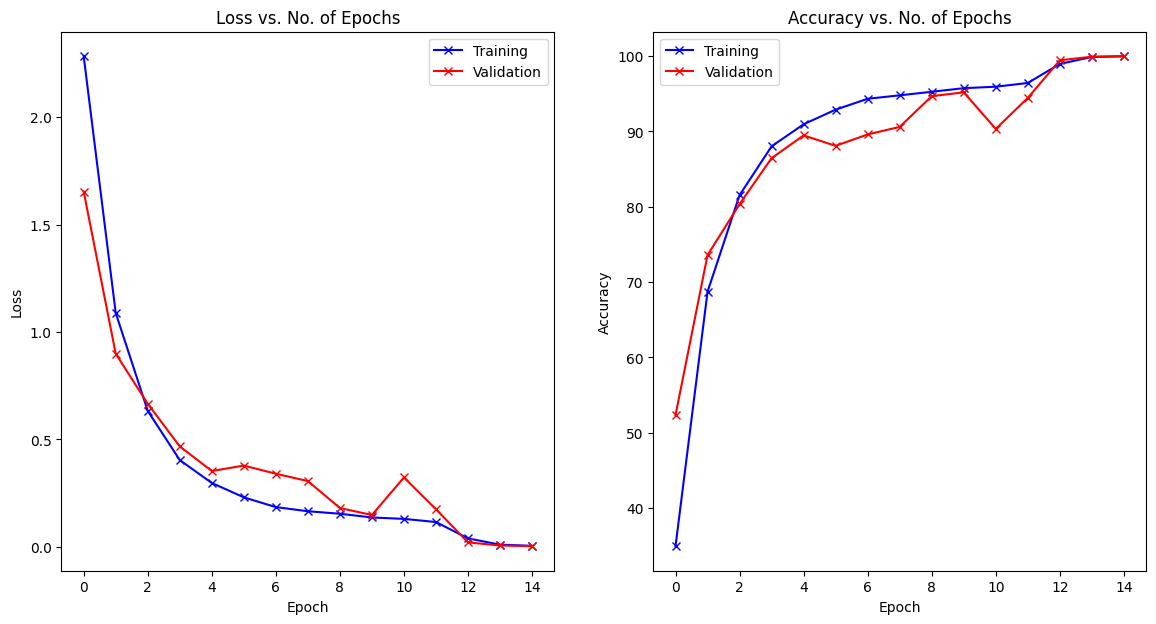

In [ ]:
subplots, ax = plt.subplots(1,2, figsize=(14,7))
# Loss
ax[0].plot(train_losses, '-bx')
ax[0].plot(val_losses, '-rx')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(['Training', 'Validation'])
ax[0].set_title('Loss vs. No. of Epochs')
# Accuracy
ax[1].plot(train_accuracies, '-bx')
ax[1].plot(val_accuracies, '-rx')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Training', 'Validation'])
ax[1].set_title('Accuracy vs. No. of Epochs')

plt.show()

Si può anche visualizzare la matrice di confusione con la funzione <code>plotConfusionMatrix()</code>:

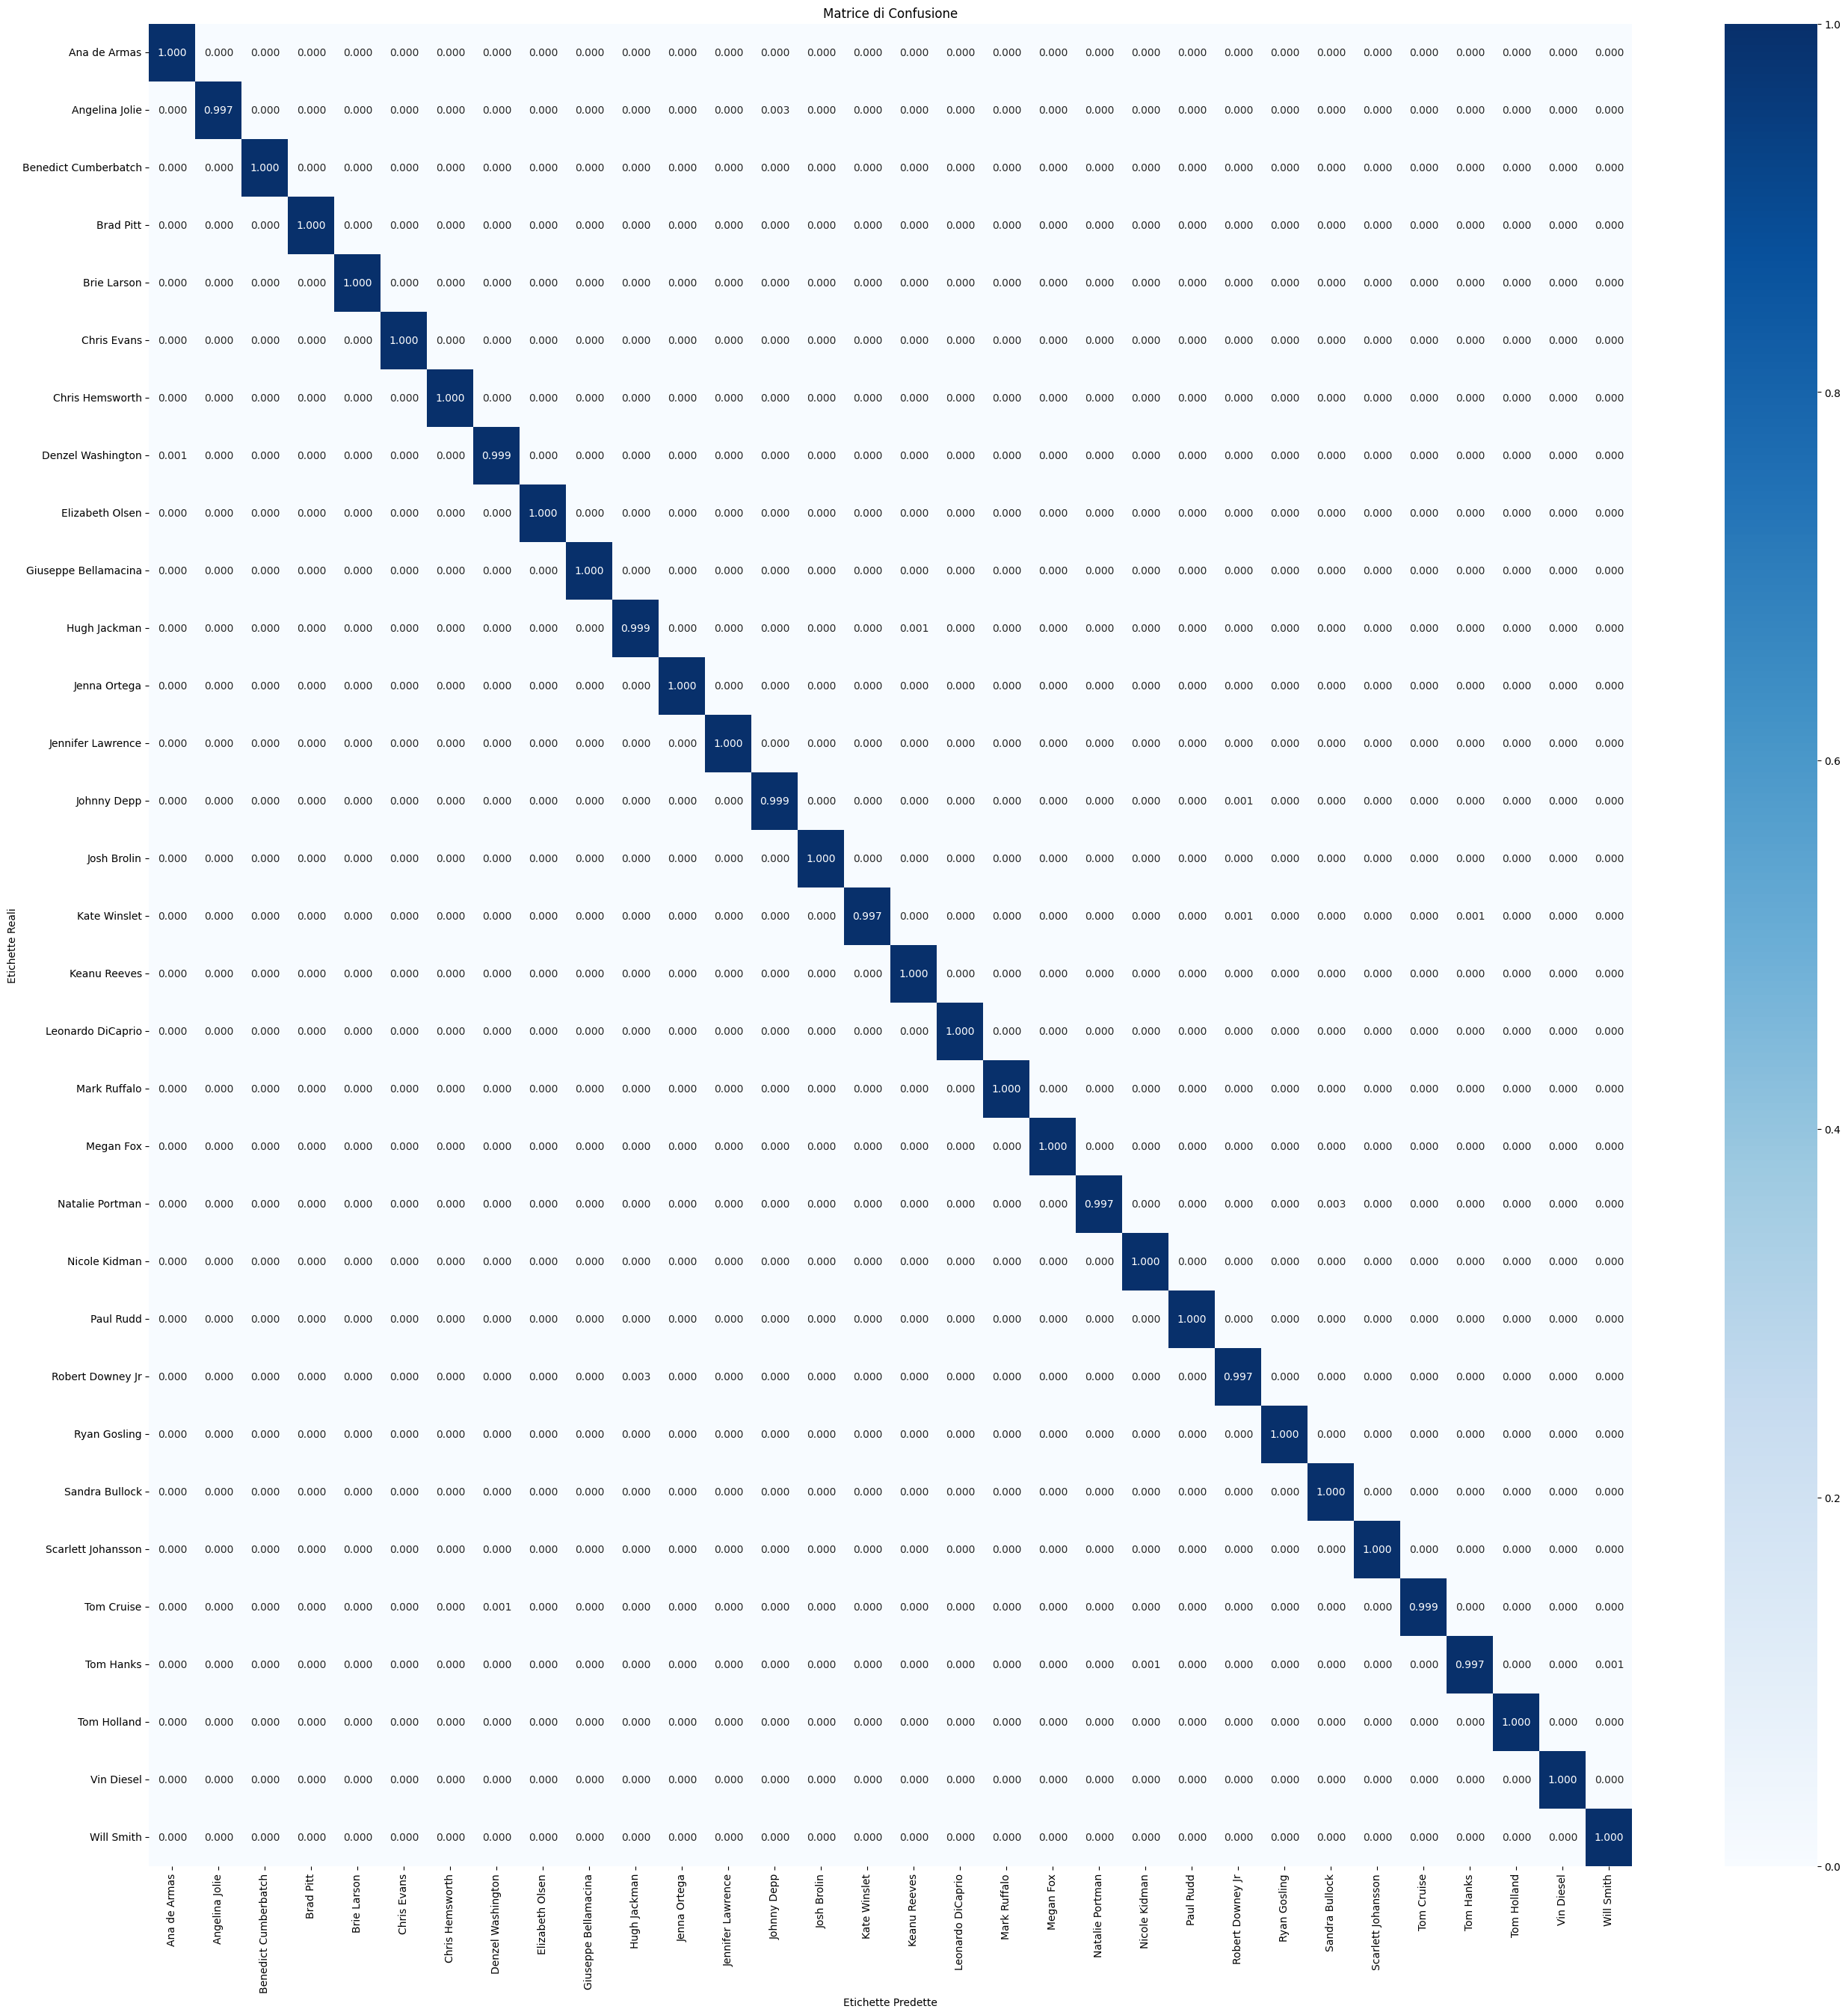

In [ ]:
def plotConfusionMatrix(y_true, y_pred, class_names, n_last_epochs=CONFUSION_DATA_EPOCHS):
    if len(y_true) < n_last_epochs:
        n_last_epochs = len(y_true)
    y_true = np.array(y_true[-n_last_epochs:]).flatten()
    y_pred = np.array(y_pred[-n_last_epochs:]).flatten()
    
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalizza la matrice di confusione
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalizzazione per righe

    plt.figure(figsize=(len(class_names), len(class_names)))
    sns.heatmap(cm, annot=True, fmt=".3f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Etichette Predette')
    plt.ylabel('Etichette Reali')
    plt.title('Matrice di Confusione')
    plt.show()


# Visualizza la matrice di confusione
plotConfusionMatrix(y_true, y_pred, classes)

<h2>Testing</h2>
Ora il modello è pronto per essere utilizzato per il riconoscimento. Si carica un <strong>Test Set</strong> le cui immagini non sono state ridimensionate per poterle visualizzare in modo più chiaro. Il Test Set in questione è formato dalle immagini originali del dataset.
Altrimenti si può caricare lo stesso dataset utilizzato per il training e includere le immagini trasformate.

In [ ]:
model.eval() # impostiamo il modello in modalità valutazione

test_set = ImageFolder(RESIZED_SET_DIR, transform=transforms.ToTensor()) # viene usato il dataset delle immagini ridimensionate
print('Dimensione del Test Set:', len(test_set))

Dimensione del Test Set: 4769


Viene definita la funzione <code>plotGrid()</code> per visualizzare più predizioni in una volta sola.

In [ ]:
def plotGrid(dim, dataset, true_labels, predicted_labels, images, tranformed_images):
    fig = plt.figure(figsize=(dim[1]*3.5,dim[0]*3.65))
    subfigs = fig.subfigures(dim[0],dim[1])
    
    z = 0
    for i in range(dim[0]):
        for j in range(0, dim[1], 2):
            axs = subfigs[i][j].subplots()
            axs.imshow(images[z].permute(1, 2, 0))
            axs.set_title(f'Immagine Originale\nReale: {dataset.classes[true_labels[z]]}', fontsize=12, fontweight='bold')
            
            axs = subfigs[i][j+1].subplots()
            axs.imshow(tranformed_images[z].permute(1, 2, 0))
            axs.set_title(f'Immagine Trasformata\nPredizione: {dataset.classes[predicted_labels[z]]}', fontsize=12, fontweight='bold')
            
            if true_labels[z] == predicted_labels[z]:
                subfigs[i][j].set_facecolor("green")
                subfigs[i][j+1].set_facecolor("green")
            else:
                subfigs[i][j].set_facecolor("red")
                subfigs[i][j+1].set_facecolor("red")
            z += 1
    
    plt.show()

Si visualizza dunque una griglia di immagini (originali e trasformate) con le relative predizioni. La griglia comprende un'immagine per ogni classe.

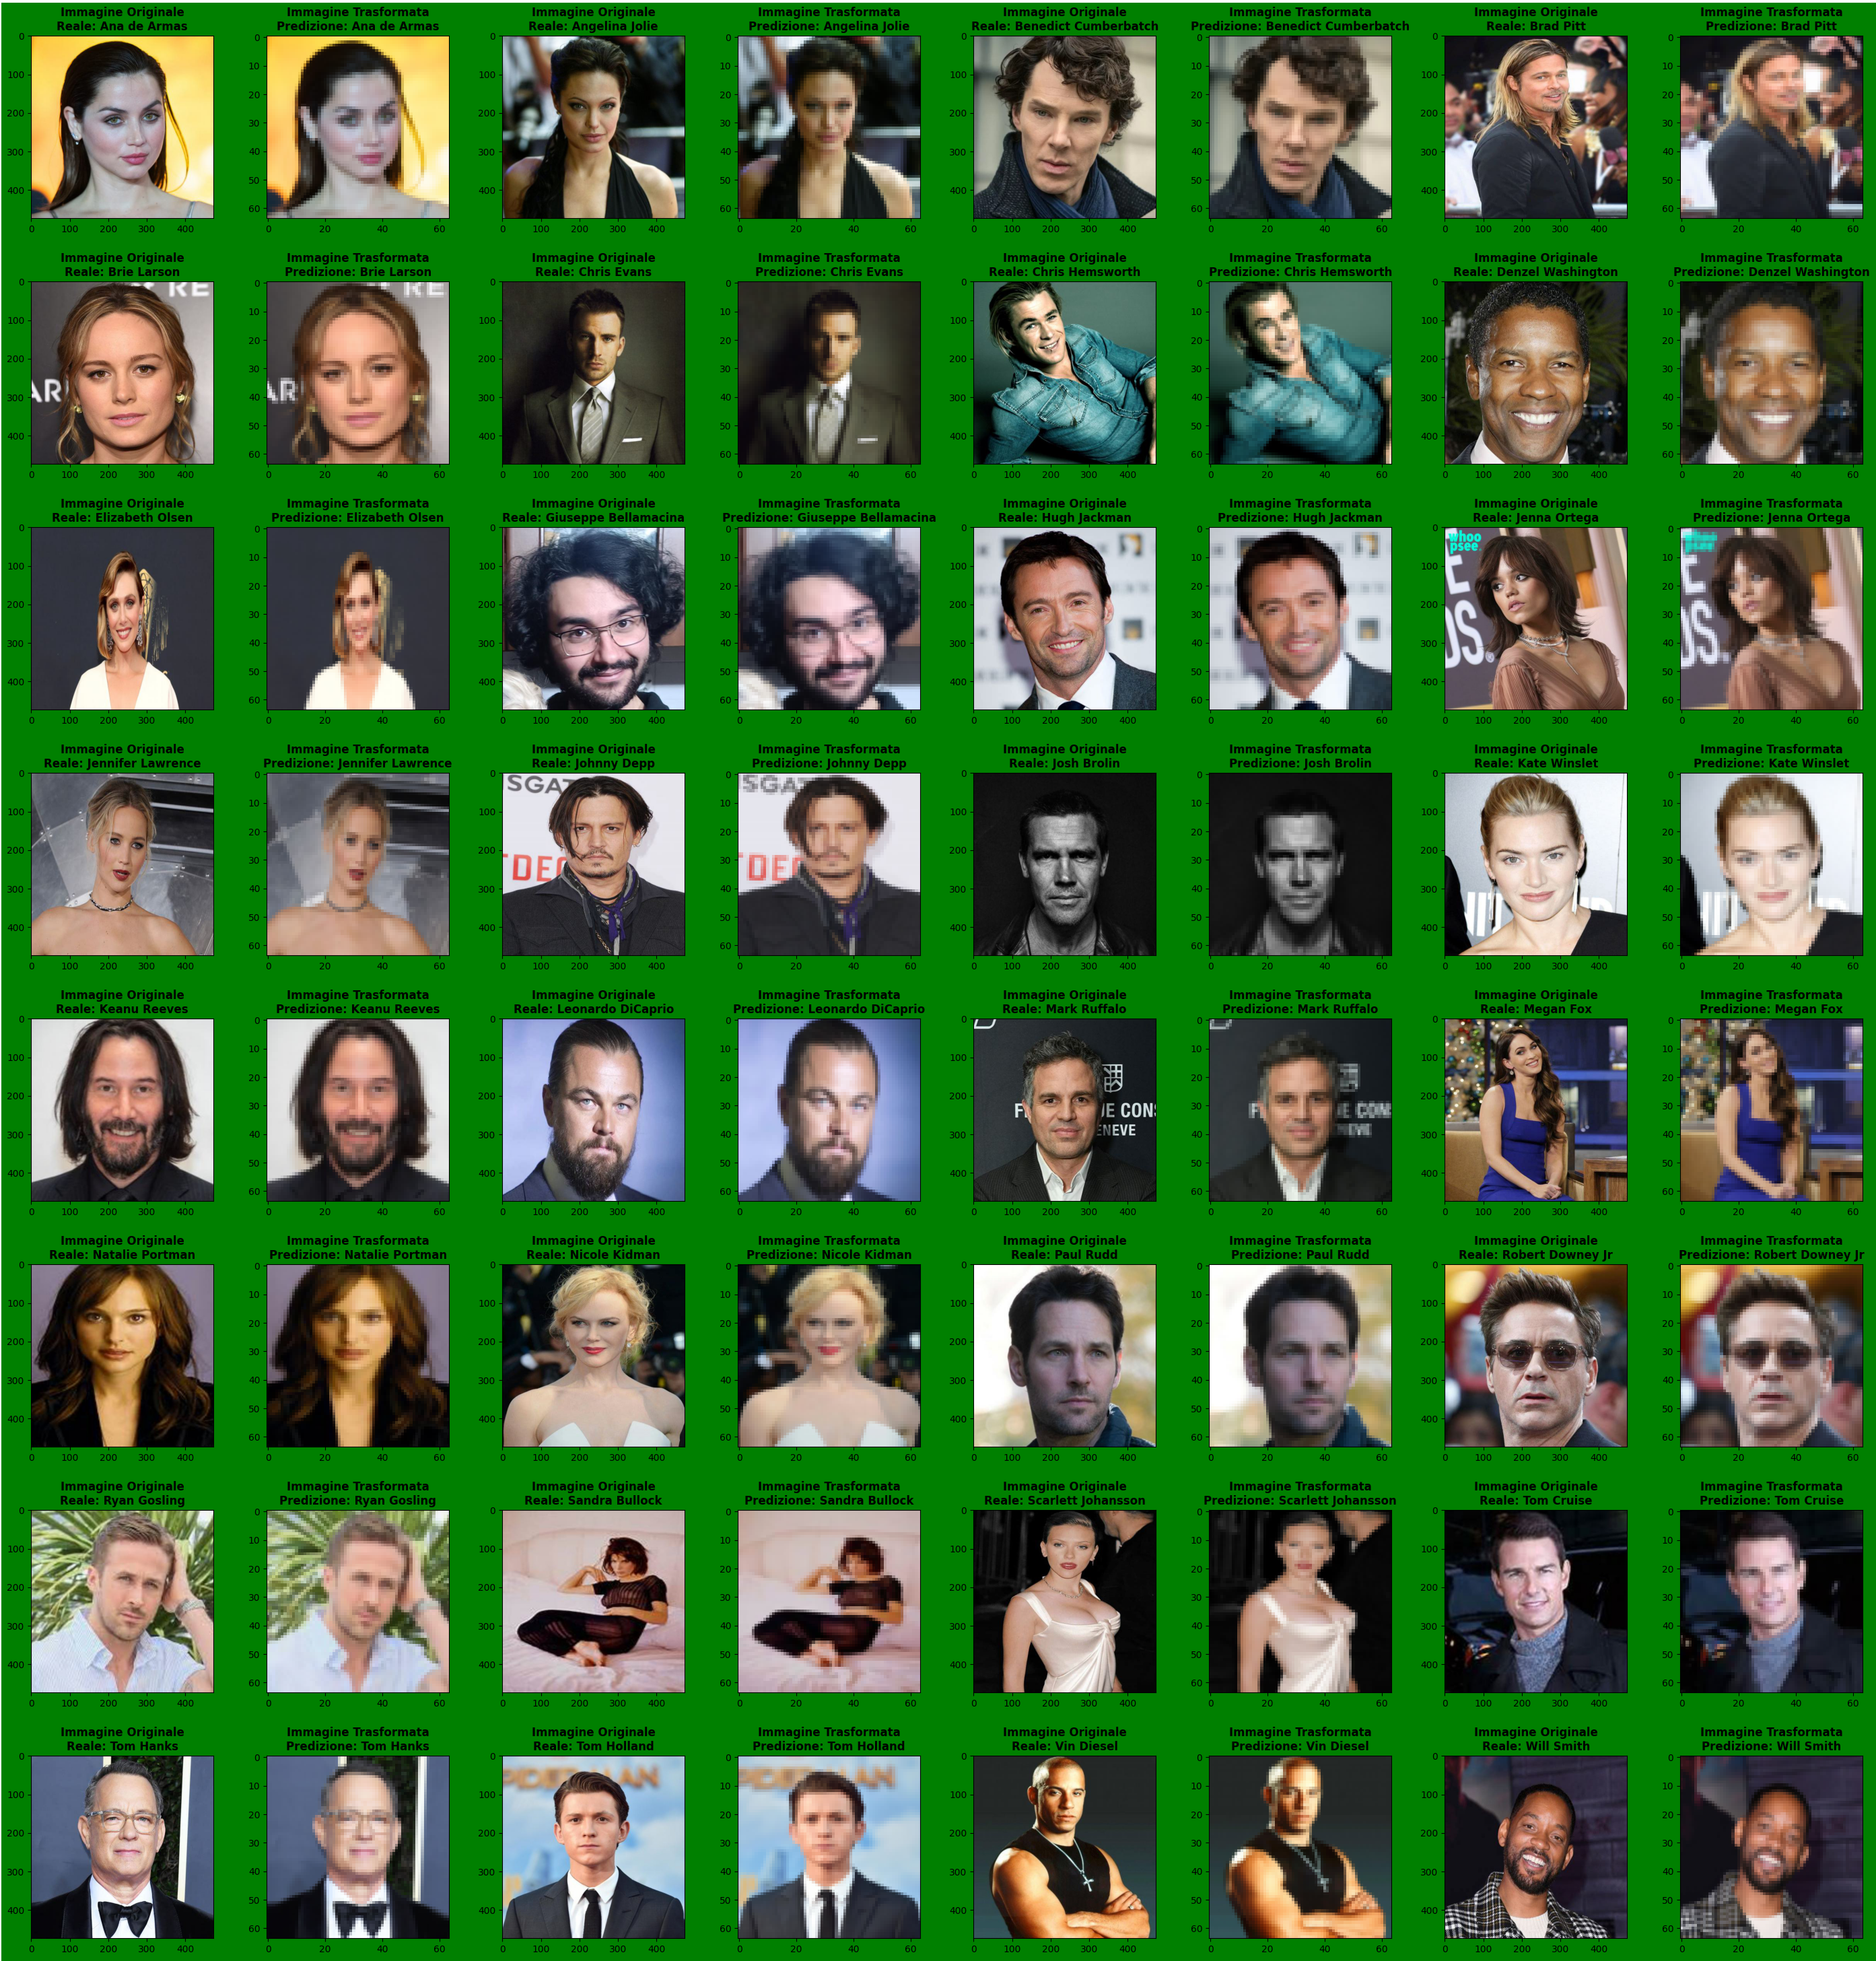

In [ ]:
### TEST sul test set ###

true_labels = []
predicted_labels = []
images = []
tranformed_images = []

class_indexes = Counter(test_set.targets)
index = 0
for i in range(32): # effettuiamo il test su 32 immagini, una per classe
    img, label = test_set[index + randint(0, class_indexes[i] - 1)]
    index += class_indexes[i]
    true_labels.append(label)
    images.append(img)
    img_transformed = transform(to_pil_image(img))
    tranformed_images.append(img_transformed)
    to_predict = img_transformed.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(to_predict)
    _, preds = torch.max(output, dim=1)
    predicted_labels.append(preds[0].item())

# Visualizza le immagini originali e quelle trasformate con la relativa predizione    
plotGrid((8,8), test_set, true_labels, predicted_labels, images, tranformed_images)

Un'altra possibilità è quella di caricare un'immagine da file sul momento e utilizzarla per il riconoscimento.
Per fare ciò è necessario caricarla in un dataset fittizio e specificare la classe corretta. Per fare ciò si utilizza la funzione <code>createSingleTestDataset()</code>.

In [ ]:
dummy_img = 'black.png'

def createSingleTestDataset(dataset, img_path, class_number):
    if os.path.exists('./test'):
        rmtree('./test')
    os.mkdir('./test')
    for cl in range(len(dataset.classes)):
        os.mkdir(f'./test/{dataset.classes[cl]}')
        if cl != class_number:
            copy(dummy_img, f'./test/{dataset.classes[cl]}')
        else:
            copy(img_path, f'./test/{dataset.classes[cl]}')
    return ImageFolder('./test', transform=transforms.ToTensor())

A questo punto l'utente può specificare l'immagine da utilizzare per il riconoscimento che viene caricata nella classe selezionata.

In [ ]:
img_path = './test_images/' + input("Inserisci il path dell'immagine da testare: ")
while not os.path.exists(img_path):
    print(f"\33[1;31mERRORE\33[0m: L'immagine {img_path} non e' stata trovata")
    img_path = './test_images/' + input("Inserisci il path dell'immagine da testare: ")
print(f"Immagine selezionata: \33[1;36m{img_path}\33[0m\n")

printLabels(classes)

class_number = input("Inserisci il numero della classe: ")
while class_number == '' or not class_number.isdigit() or int(class_number) < 1 or int(class_number) > len(classes):
    print(f"\33[1;31mERRORE\33[0m: Numero non valido")
    class_number = input("Inserisci il numero della classe: ")
print(f"\nClasse selezionata: \33[1;34m{classes[int(class_number)-1]}\33[0m")

class_number = int(class_number) - 1
single_test = createSingleTestDataset(test_set, img_path, class_number)

Immagine selezionata: ./test_images/keanu.jpg

Classi:
1. Ana de Armas                17. Keanu Reeves
2. Angelina Jolie              18. Leonardo DiCaprio
3. Benedict Cumberbatch        19. Mark Ruffalo
4. Brad Pitt                   20. Megan Fox
5. Brie Larson                 21. Natalie Portman
6. Chris Evans                 22. Nicole Kidman
7. Chris Hemsworth             23. Paul Rudd
8. Denzel Washington           24. Robert Downey Jr
9. Elizabeth Olsen             25. Ryan Gosling
10. Giuseppe Bellamacina       26. Sandra Bullock
11. Hugh Jackman               27. Scarlett Johansson
12. Jenna Ortega               28. Tom Cruise
13. Jennifer Lawrence          29. Tom Hanks
14. Johnny Depp                30. Tom Holland
15. Josh Brolin                31. Vin Diesel
16. Kate Winslet               32. Will Smith

Classe selezionata: Keanu Reeves


Dunque si visualizzano i risultati del riconoscimento:

Predizione Corretta


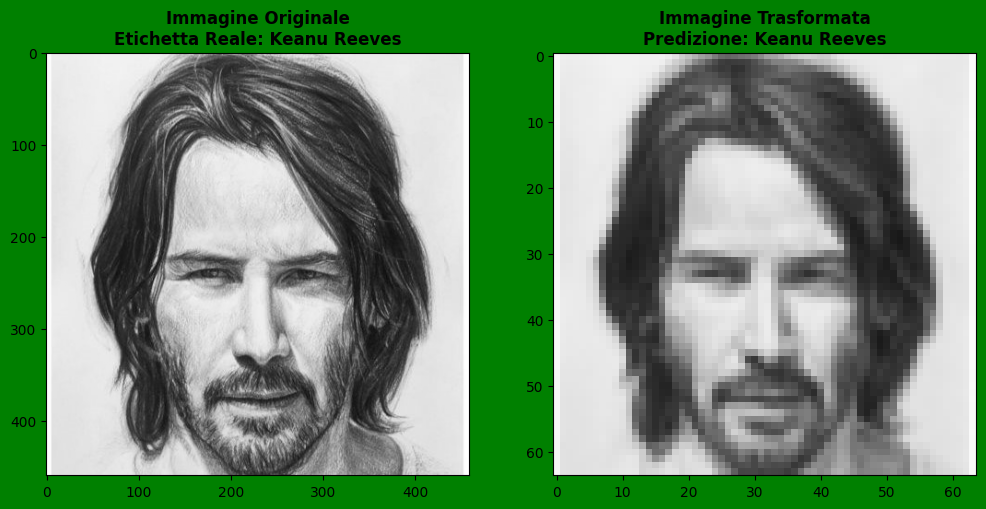

In [ ]:
### TEST su un'immagine data dall'utente ###

img, label = single_test[class_number]
img_transformed = transform(to_pil_image(img))
to_predict = img_transformed.unsqueeze(0).to(device)
with torch.no_grad():
    output = model(to_predict)
_, preds = torch.max(output, dim=1)

# Veifichiamo se la predizione è corretta
if single_test.classes[label] == single_test.classes[preds[0].item()]:
    print("\33[1;32mPredizione Corretta\33[0m")
    color = 'green'
else:
    print("\33[1;31mPredizione Errata\33[0m")
    color = 'red'

# Visualizziamo l'immagine originale e quella trasformata
fig, ax = plt.subplots(1, 2, figsize=(12, 8), facecolor=color)
ax[0].imshow(img.permute(1, 2, 0))
ax[0].set_title(f'Immagine Originale\nEtichetta Reale: {single_test.classes[label]}', fontsize=12, fontweight='bold')

ax[1].imshow(img_transformed.permute(1, 2, 0))
ax[1].set_title(f'Immagine Trasformata\nPredizione: {single_test.classes[preds[0].item()]}', fontsize=12, fontweight='bold')

plt.show()
rmtree('./test') # eliminiamo la cartella del dataset fittizio